# Analyzing NYC High School Data

This project covers data on New York City (NYC) High Schools. I will be analyzing relationships between SAT scores, school attendance, class size, AP test results, graduation outcomes and demographics. NYC has a diverse and high immigrant population compared to other cities in the United States.

***
Learning Goals:
    - Analyzing data
    - Visualizing data effectively
    


## Part 1: Cleaning and Exploring the Data

### Read in the data

I will start by reading in the data from the various datasets. 

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
# display the first five rows of each of the datasets
for key in data:
    df = data[key]
    print(key)
    print("\n")
    print(df.head())

ap_2010


      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
class_size


   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K

Each dataset has information about `DBN` - a code to identify a school. We can condense this data to one row later. 

### Read in the surveys

Reading in the two text files. 

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

There were over 2000 columns of data in the survey fields, however, I picked out the ones relevant to this project A data dictionary can be found <a https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8>here</a> or below.

* dbn School identification code (district borough number)
* sch_type	School type (Elementary, Middle, High, etc)
* location	School name
* enrollment	Enrollment size
* borough	Borough
* principal	Principal name
* studentsurvey	Only students in grades 6-12 partipate in the student survey. This field  indicates whether or not this school serves any students in grades 6-12.
* rr_s	Student Response Rate
* rr_t	Teacher Response Rate
* rr_p	Parent Response Rate
* N_s	Number of student respondents
* N_t	Number of teacher respondents
* N_p	Number of parent respondents
* nr_s	Number of eligible students
* nr_t	Number of eligible teachers
* nr_p	Number of eligible parents
* saf_p_11	Safety and Respect score based on parent responses
* com_p_11	Communication score based on parent responses
* eng_p_11	Engagement score based on parent responses
* aca_p_11	Academic expectations score based on parent responses
* saf_t_11	Safety and Respect score based on teacher responses
* com_t_11	Communication score based on teacher responses
* eng_t_11	Engagement score based on teacher responses
* aca_t_11	Academic expectations score based on teacher responses
* saf_s_11	Safety and Respect score based on student responses
* com_s_11	Communication score based on student responses
* eng_s_11	Engagement score based on student responses
* aca_s_11	Academic expectations score based on student responses
* saf_tot_11	Safety and Respect total score
* com_tot_11	Communication total score
* eng_tot_11	Engagement total score
* aca_tot_11	Academic Expectations total score

### Add DBN columns

Any place there is a `dbn` column in the files - `hs_directory`. I will convert this to uppercase `DBN`. Additionally, `class_size` has two different columns containing DBN information. I will combine them into one column. To do this, I will also need to add a leading `0` so that that it matches the other `DBN` columns. 

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# checking class_size
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


### Condense datasets

As seen above, the `class_size` data set contains multiple rows of the same `DBN`. I will condense all rows to a single unique value of `DBN` which will help with analysis later. Another contraining factor is the `GRADE` column. I only need the values for grads 9 - 12. Similarly, `GEN ED` is the largest value in the column `Program Type`, thus I will use it as a factor in condensimg rows as well.

In [5]:
# condensing rows of class_size

# creating a class size dataframe
class_size = data["class_size"]

# filter by rows where GRADE == 9-12
class_size = class_size[class_size["GRADE "] == "09-12"]

# filter for rows where the rogram type == GEN ED
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


Multiple rows still contain the same DBN value in `class_size`. To further condense the rows, I need to take the average of the `CORE COURSE` and the `CORE SUBJECT` columns.

Also, I only want values for courses in the 2012 schoolyear or the most recent data.

In [6]:
class_size = class_size.groupby("DBN").agg(np.mean)

class_size.reset_index(inplace=True)
data["class_size"] = class_size

data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


In [7]:
# filter by schoolyear 2012
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]


Now, I can condense the `graduation` dataset. The `Demographic` and `Cohort` columns are the ones preventing `DBN` from being unique. I will filter the data from the most recent cohort, `2006`. I also want data from the full cohort, so I will select rows where `Demographic` is `Total Cohort` as well.


In [8]:

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


### Convert columns to numeric

The `sat_results` dataframe has SAT score data in string type instead of numeric type. I will convert ot numeric so I can perform analysis later. 

In [9]:
#converting SAT scores into numeric type
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")




In [10]:
# creating a new column for sum of the SAT category scores
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

data['sat_results']['sat_score'].head()

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

Now, I will extract the latitude and longitude of each school. This wil be useful to map and track geographic patterns in the data. The location data is in the `Location 1` column of the `hs_directory` dataset. 

In [11]:
# finding latitude and longitude

# creating functions to extract lat and lon
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# assigning to new columns
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)


# converting to numeric
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Convert AP scores to numeric

Moving on to the `ap_2010` dataframe, I will convert the AP test results into a numeric type format.

In [12]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

With clean data, I can merge the datasets together. The datasets are related by the `DBN` coulmn.

In [13]:
# merge sat_results, ap_2010, and graduation together

combined = data['sat_results'].merge(data['graduation'], how='left', on='DBN')
combined = combined.merge(data["graduation"], on="DBN", how="left")


In [14]:
# list of datasets to merge into combined

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

    
print(combined.head())
print(combined.shape)

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score Demographic_x  \
0                404.0                   363.0     1122.0  Total Cohort   
1                423.0                   366.0     1172.0  Total Cohort   
2                402.0 

The result has missing values. I will use the mean of each column to fill missing values. In cases where all values in a column are null, the values will be filled with zeroes.

In [15]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Demographic_x,School Name_x,Cohort_x,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,Total Cohort,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,Total Cohort,EAST SIDE COMMUNITY SCHOOL,2006,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,Total Cohort,MARTA VALLE HIGH SCHOOL,2006,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,Total Cohort,NEW EXPLORATIONS INTO SCIENCE TECHNO,2006,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


The data is clean and ready for analysis, however there are a few things left to add intrigue to the analysis.

### Add a school district column for mapping

Looking at the school district, which depends on geographical area, might be interesting. The school district is the first two characters of the `DBN`. I will extract those calues and put them into a new column.

In [16]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

combined["school_dist"].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

## Part 2: Analyzing the Data

### Finding correlations with SAT Scores

To begin, I will look at pearson coefficient values (r-values). These values indicate that there might be a correlation between two factors. In this case, I wanted to check if there are possible correlations between `sat_scores`and any other column.  

In [17]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

#calculating r-values

correlations = combined.corr(method='pearson')
correlations = correlations["sat_score"]
print(correlations)


SAT Critical Reading Avg. Score    0.986821
SAT Math Avg. Score                0.972664
SAT Writing Avg. Score             0.987835
sat_score                          1.000000
Total Cohort_x                     0.326443
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.122115
lon                               -0.131803
Name: sat_score, Length: 65, dtype: float64


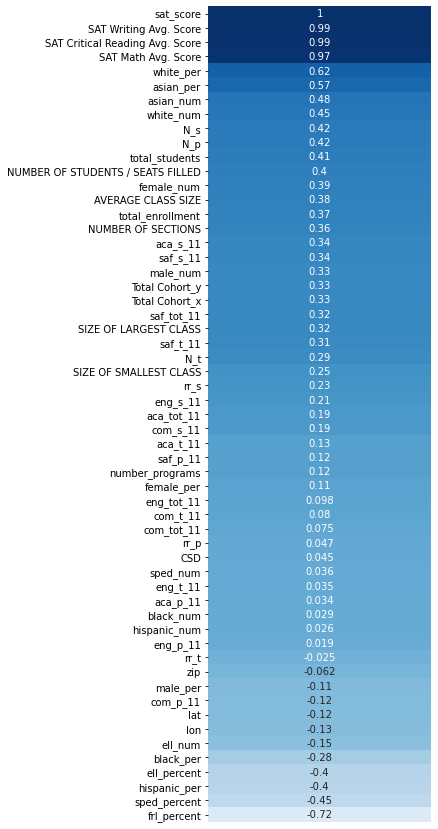

In [18]:
# visualizing r-vales in a heatmap

# droping null values and sorting
correlations = correlations.dropna()
sorted_correlations = correlations.sort_values(ascending=False)

%matplotlib inline

plt.figure(figsize=(4,15))
resized_sort = np.asarray(sorted_correlations).reshape(57, 1)
ax = sns.heatmap(resized_sort, vmin=-1, vmax=1, annot=True, 
                 xticklabels=False, yticklabels=sorted_correlations.keys(),
                 cmap='Blues', cbar=False)

Relevant r-values will be above 0.25 or below -0.25. Looking at the heatmap above, some correlations standout.

* `SAT Critical Reading Avg. Score`, `SAT Writing Avg. Score`, and `SAT Math Avg. Score` are strongly correlated with `sat_score`. This is an unsurprising reslt since `sat_score` is the sum of these averages. 
* Columns tracking similar data such as `total_students`, `N_s`, `N_p`, `NUMBER OF STUDENTS/SEATS FILLED`, `AVERAGE CLASS SIZE`, and `total_enrollment` all indicate a correlation between larger schools and higher average SAT scores. 
* The heatmap also suggests that there is a correlation between the race of the student and average SAT scores. For instance, higher percentages of White and Asian students at a school correlates with higher SAT score averages while schools with higher populations of black and hispanic students tend to have lower SAT school averages. Thus, there seems to be racial inequality in SAT scores.
* On the other hand, there is a positive correlation between SAT scores and sex of the student. Female students (`female_num` has r = 0.39) have a slightly more positive correlation to SAT scores than male students (`male_num` has r = 0.33). However, looking at the percentage of male (`male_per`) and female students (`female_per`), there is a slight negative correlation between SAT scores and percentage of males stdents and a slight positive correlation for female students. These different values suggests that SAT scores are not biased on the basis of sex.
* School safety ratings from both students and teachers (`saf_t_11`, `saf_tot_11` and `saf_s_11`) correlate with SAT scores
* Ratings of academic standards from students, `aca_s_11` correlates with SAT scores, but parent and teacher academic ratings (`aca_p_11` and `aca_t_11`) do not have a correlation with SAT scores.
* The percentage of English language learners (`ell_percent`) and students using free and reduced lunch (`frl_percent`) attending a school has a negative correlation with SAT scores. This is unsurrising considering the SAT is an exam written in English.

### Total Enrollment and SAT Scores

Since the `total_enrollment` column shows a significant pearson coffecient value with SAT score, I will create a scatter plot to verify a correlation. 

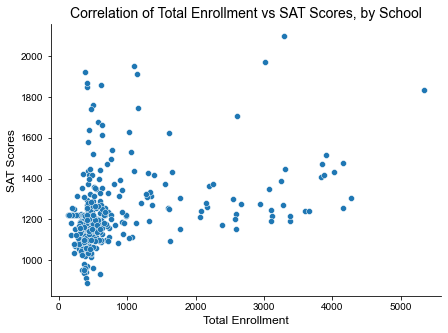

In [19]:
# scatter plot of total enrollment vs SAT score

fig, ax = plt.subplots(figsize=(7,5))
sns.set_style('white')

ax = sns.scatterplot(data=combined, x='total_enrollment', y='sat_score')

ax.set_title('Correlation of Total Enrollment vs SAT Scores, by School', fontsize=14)
ax.set_xlabel('Total Enrollment', fontsize=12)
ax.set_ylabel('SAT Scores', fontsize=12)

sns.despine()


Based on the scatterplot above, there is no clear correlation between total student enrollment and SAT scores. Nevertheless, the cluster at the bottom left of the plot, low enrolment and low scores, may be skewing the results to suggest that there is a correlation. I will extract the names of the schools for further investigation. 

In [20]:
low_enrollment = combined[(combined['total_enrollment'] < 1000) & (combined['sat_score'] < 1000)]
low_enrollment.T

,90,124,125,138,140,175,178,187,224,236,252,285
DBN,07X334,09X365,09X403,10X268,10X342,12X388,12X550,13K439,17K524,18K563,19K583,24Q296
SCHOOL NAME,INTERNATIONAL COMMUNITY HIGH SCHOOL,ACADEMY FOR LANGUAGE AND TECHNOLOGY,BRONX INTERNATIONAL HIGH SCHOOL,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,HIGH SCHOOL OF WORLD CULTURES,BROOKLYN INTERNATIONAL HIGH SCHOOL,INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS,IT TAKES A VILLAGE ACADEMY,MULTICULTURAL HIGH SCHOOL,PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Num of SAT Test Takers,34,54,49,52,49,30,42,90,71,56,29,55
SAT Critical Reading Avg. Score,310,315,314,304,300,321,304,305,287,313,279,317
SAT Math Avg. Score,324,339,312,356,333,351,323,364,335,320,322,323
...,...,...,...,...,...,...,...,...,...,...,...,...
priority10,0,0,0,0,0,0,0,0,0,0,0,0
Location 1,"345 Brook Avenue\nBronx, NY 10454\n(40.8100361...","1700 Macombs Road\nBronx, NY 10453\n(40.849102...","1110 Boston Road\nBronx, NY 10456\n(40.8276026...","2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...","2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...","1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...","1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...","49 Flatbush Avenue Extension\nBrooklyn, NY 112...","883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...","5800 Tilden Avenue\nBrooklyn, NY 11203\n(40.64...","999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...","45-10 94Th Street\nElmhurst, NY 11373\n(40.743..."
lat,40.81,40.8491,40.8276,40.8704,40.8704,40.8314,40.8314,40.6972,40.6703,40.6487,40.6911,40.7433
lon,-73.9178,-73.9161,-73.9045,-73.8982,-73.8982,-73.8788,-73.8788,-73.985,-73.9616,-73.9219,-73.8684,-73.8706


Using the New York State Department of Education's [School Report website](https://data.nysed.gov/lists.php?type=school), I did some background research on the schools. Noticing that many of these schools are inernational, it is not surprising that they have a higher enrolment of ELL students. With this in mind, it would appear that the correlation lies with the percent of ELL students attending the school and not total enrollment.

### English Language Learners and SAT Scores

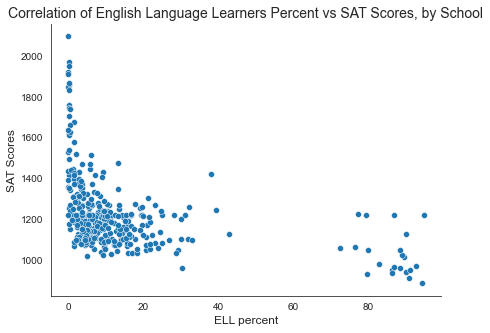

In [21]:
# scatterplot of ell_percent vs SAT scores

fig, ax = plt.subplots(figsize=(7,5))
sns.set_style('white')

ax = sns.scatterplot(data=combined, x='ell_percent', y='sat_score')

ax.set_title('Correlation of English Language Learners Percent vs SAT Scores, by School', fontsize=14)
ax.set_xlabel('ELL percent', fontsize=12)
ax.set_ylabel('SAT Scores', fontsize=12)

sns.despine()

The scatterplot verfies that SAT scores and the percentage of English Language Learners attending a school have a negative correlation. Next, I will use geospatial data to map out where ELL are most concentrated. The maps used in this project can be found [here (Borough Map)](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) and [here (School District Map)](https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj).

   boro_code      boro_name    shape_area     shape_leng  \
0        1.0      Manhattan  6.366038e+08  361611.823950   
1        2.0          Bronx  1.187245e+09  464650.051822   
2        3.0       Brooklyn  1.934091e+09  729592.941749   
3        4.0         Queens  3.044042e+09  900087.667215   
4        5.0  Staten Island  1.623757e+09  325956.009000   

                                            geometry  
0  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
1  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...  
2  MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...  
3  MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...  
4  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  


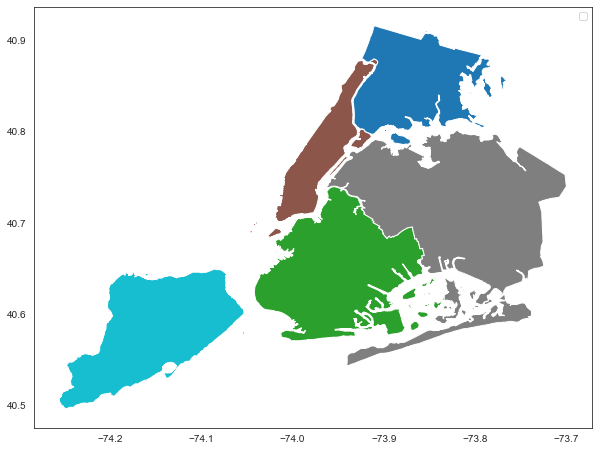

In [145]:
#import libraries for geospatial data

import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import plotly.express as px
import descartes
import imageio
import pathlib
import matplotlib.animation as animation
from shapely.geometry import Point, Polygon
import mapclassify as mc

%matplotlib inline

# read in shapefiles for maps by borough boundary and school district boundary

shape_file_boro = 'C:/Users/Laurelle/Documents/Programming Projects/python_projects/nyc_sat_data/geo_export_e74ca12c-a4c7-4fde-a8ca-36a2abc1d528.shp'
nyc_boro = gpd.read_file(shape_file_boro)
print(nyc_boro.head())

shape_file_sd = 'C:/Users/Laurelle/Documents/Programming Projects/python_projects/nyc_sat_data/geo_export_734083e0-d485-424d-8455-8220200a5ab1.shp'
nyc_sd = gpd.read_file(shape_file_sd)

# Boroughs of New York City for Reference
ax = nyc_boro.plot(column=nyc_boro['boro_name'], figsize=(10,10))
labels = nyc_boro['boro_name']
ax.legend(labels)

In [23]:
# renaming column to match with other data

nyc_sd['school_dis'] = nyc_sd['school_dis'].sort_values(ascending=False)
nyc_sd['school_dis'] = nyc_sd['school_dis'].astype(str)
nyc_sd['school_dis']

0      1.0
1     10.0
2     11.0
3     16.0
4     12.0
5     13.0
6     14.0
7     15.0
8      6.0
9      7.0
10     8.0
11    17.0
12    18.0
13    19.0
14     2.0
15    20.0
16    21.0
17    22.0
18    23.0
19    24.0
20    25.0
21    26.0
22    27.0
23    28.0
24    29.0
25     3.0
26    30.0
27    31.0
28    32.0
29     4.0
30    10.0
31     5.0
32     9.0
Name: school_dis, dtype: object

In [55]:
# creating the points for the map

district = combined.groupby('school_dist').agg(np.mean).reset_index()

# extractimg geometry points from district dataframe
points = [Point(xy) for xy in zip(district['lon'], district['lat'])]

district['points'] = points
district.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Total Cohort_x,Total Cohort_y,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,...,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,points
0,01,441.833333,473.333333,439.333333,1354.500000,93.500000,93.500000,1.0,115.244241,5.148538,...,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377,POINT (-73.98237720066633 40.71902243866714)
1,02,426.608658,444.176397,424.814746,1295.599800,158.713390,158.713390,2.0,149.818949,5.686360,...,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386,POINT (-73.99138567329133 40.73969949983381)
2,03,428.508982,437.977794,426.879491,1293.366267,183.496764,183.496764,3.0,156.005994,5.839200,...,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370,POINT (-73.97737016149965 40.78157410950048)
3,04,397.166667,411.333333,398.666667,1207.166667,123.666667,123.666667,4.0,143.040289,5.607065,...,12.0,10030.000000,600.333333,1.166667,0.0,0.0,0.0,40.793572,-73.942534,POINT (-73.94253445066632 40.79357249066714)
4,05,427.147990,438.225406,419.645423,1285.018820,143.805825,143.805825,5.0,120.623901,4.845101,...,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251,POINT (-73.94925139814252 40.81707656500047)


In [26]:
frames = [district, nyc_sd]
merged_sd = pd.concat(frames, axis=1)


from geopandas import GeoDataFrame

merged_sd = GeoDataFrame(merged_sd)
merged_sd.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Total Cohort_x,Total Cohort_y,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,...,priority08,priority09,priority10,lat,lon,points,school_dis,shape_area,shape_leng,geometry
0,01,441.833333,473.333333,439.333333,1354.500000,93.500000,93.500000,1.0,115.244241,5.148538,...,0.0,0.0,0.0,40.719022,-73.982377,POINT (-73.98237720066633 40.71902243866714),1.0,3.516033e+07,28641.223059,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
1,02,426.608658,444.176397,424.814746,1295.599800,158.713390,158.713390,2.0,149.818949,5.686360,...,0.0,0.0,0.0,40.739699,-73.991386,POINT (-73.99138567329133 40.73969949983381),10.0,2.825410e+08,94956.718074,"POLYGON ((-73.86790 40.90294, -73.86796 40.902..."
2,03,428.508982,437.977794,426.879491,1293.366267,183.496764,183.496764,3.0,156.005994,5.839200,...,0.0,0.0,0.0,40.781574,-73.977370,POINT (-73.97737016149965 40.78157410950048),11.0,3.932277e+08,305035.869503,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."
3,04,397.166667,411.333333,398.666667,1207.166667,123.666667,123.666667,4.0,143.040289,5.607065,...,0.0,0.0,0.0,40.793572,-73.942534,POINT (-73.94253445066632 40.79357249066714),16.0,4.676362e+07,35848.904082,"POLYGON ((-73.93312 40.69579, -73.93237 40.695..."
4,05,427.147990,438.225406,419.645423,1285.018820,143.805825,143.805825,5.0,120.623901,4.845101,...,0.0,0.0,0.0,40.817077,-73.949251,POINT (-73.94925139814252 40.81707656500047),12.0,6.909795e+07,48578.087537,"POLYGON ((-73.88284 40.84782, -73.88200 40.847..."


An SAT score has a maximum of 1600. A mean score is 1000 points composite. I want to divide the scores into ranges to easily visualize the average test scores per school district. 

Text(0, 0.5, 'Percent of English Language Learners')

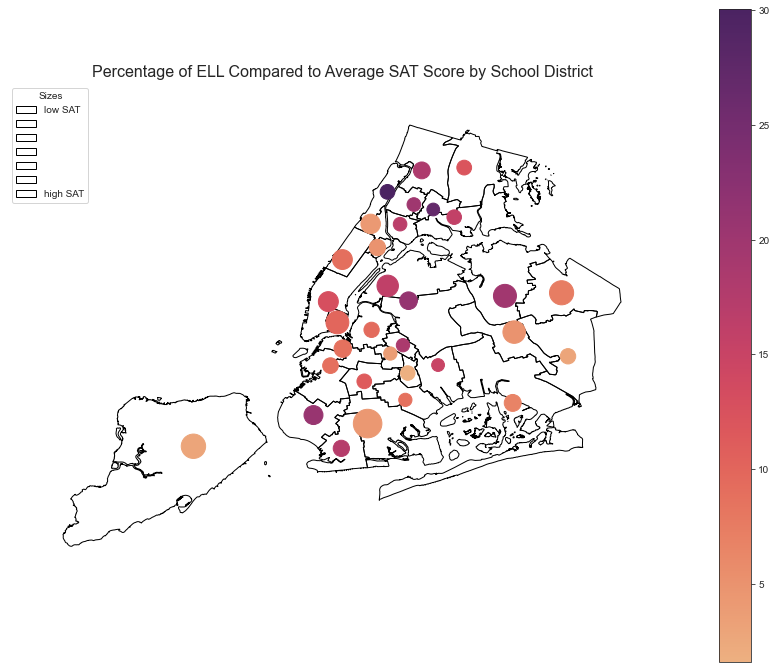

In [115]:
# district as GeoDataFrame
geo_dist = gpd.GeoDataFrame(district, geometry=points)

# plot of NYC with school disicts marked 

# variable to be visualized
variable1 = 'ell_percent'
variable2= 'sat_score'
    
# create a plot

# siing for markers
s = [8**(n/450) for n in geo_dist['sat_score']]

ax = gplt.polyplot(merged_sd, figsize=(15,12))

map1 = geo_dist.plot(column='ell_percent', markersize=s, ax=ax, cmap='flare', legend=True)

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Percentage of ELL Compared to Average SAT Score by School District', fontsize = 16, fontweight=3)

#legend to describe markers´ sizes
labels = ['low SAT', '', '', '', '', '', 'high SAT']
map1.legend(labels, loc='upper left', markerfirst=True, title='Sizes')

# x and y labels
ax.set_ylabel('Percent of English Language Learners')


A large cluster of the highest percentage of English language learner students go to school in the Bronx. As stated earlier, non-native English speakers tend to have lower average SAT scores than their native-speaking peers. 

### Survey Results

### Safety

Safety ratings of schools showed a moderate pearson coeffcient rating. To verify that there is a correlation bewteen SAT scores and school safety ratings, I wanted to plot a scatterplot. Additionally, I will look at safety by borough. 

Overall, school and teacher safety ratings are similar in terms of correlation. By that measure, the `saf_tot_11`, which represents the total school safety rating has a similar sape as wel. Because student safety ratings had the highest r-value (0.34), I will use this column to decipher borough safety scores. 

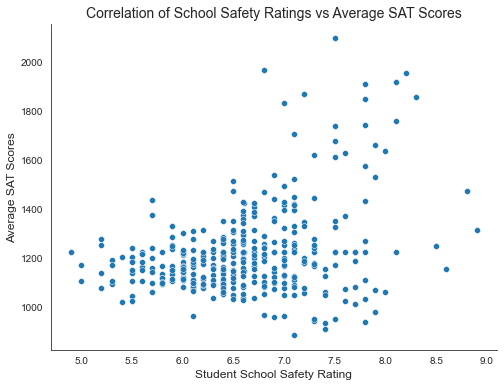

In [146]:
# saf_s_11, is the student safety and respect scores respectively

# scatterplot of Borough Safety vs Average SAT Score

fig = plt.figure(figsize=(8,6))
sns.set_style('white')

ax = sns.scatterplot(data=combined, x='saf_s_11', y='sat_score')

# labels
ax.set_title('Correlation of School Safety Ratings vs Average SAT Scores', fontsize=14, fontweight=3)
ax.set_xlabel('Student School Safety Rating', fontsize=12)
ax.set_ylabel('Average SAT Scores', fontsize=12)

sns.despine()

There appears to be a correlation between SAT scores and safety, although it is not a strong correlation. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6 has an average SAT score higher than 1600 or so. That is to say, having a high safety rating is an important factor in higher SAT averages but it is not unique in determining test scores. 

Finally, I compare safety scores and test scores on a map of school districts. 

Text(0, 0.5, 'School and Respect Safety Scores')

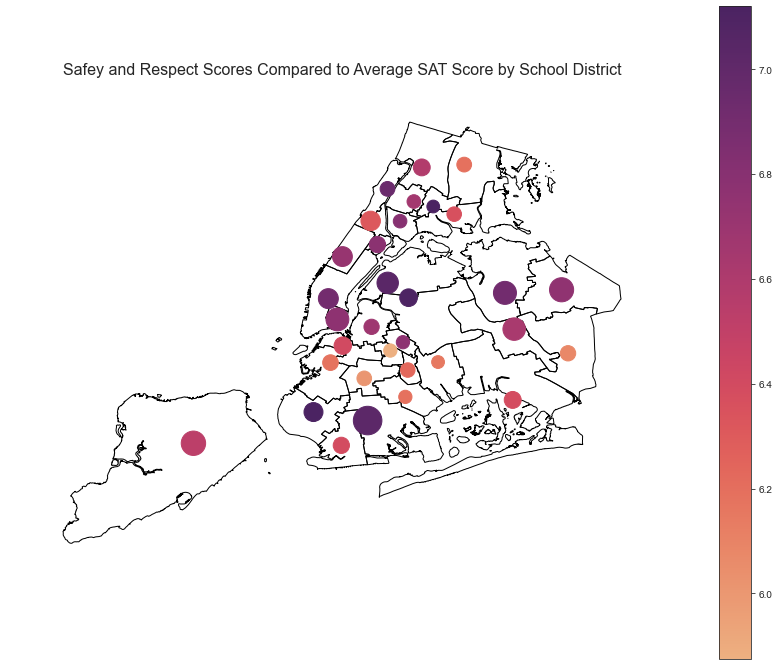

In [127]:
# plot of NYC with school disicts marked, comparing saf_s_11 and sat_score 

# variable to be visualized
variable1 = 'saf_s_11'
variable2= 'sat_score'
    
# create a plot

# siing for markers
s = [8**(n/450) for n in geo_dist['sat_score']]

ax = gplt.polyplot(merged_sd, figsize=(15,12))

map2 = geo_dist.plot(column='saf_s_11', markersize=s, ax=ax, cmap='flare', legend=True)

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Safey and Respect Scores Compared to Average SAT Score by School District', fontsize = 16, fontweight=3)

#legend to describe markers´ sizes
labels = ['low SAT', '', '', '', '', '', 'high SAT']
map1.legend(labels, loc='upper left', markerfirst=True, title='Sizes')

# x and y labels
ax.set_ylabel('School and Respect Safety Scores')

The map gives a better idea of why school safety rating is not a true indicator of higher average SAT scores. For instance, students in the Bronx rate their schools highly for safety and respect, yet these disricts have lower average SAT scores. 

### Free And Reduced Lunch (FRL) and SAT Score

Free and reduced lunch can be used as an indicator for household income because the program requires certain income levels for students to qualify. According to the [National School Lunch Program](https://frac.org/school-meal-eligibility-reimbursements), children in households with income at or below 130% of the federal poverty level qualify for free meals. Children in households where the income is in between 130% to 185% of the federal poverty level are elegible for reduced-price meals. 

In 2017, the [federal poverty threshold](https://www.healthcare.gov/glossary/federal-poverty-level-FPL/) for a family of four was $26,400 a year. 

Therefore, households with incomes below $60,720 qualify for free meals. Households between $60,720 and $75,240 qualify for reduced meals. 

In this section of the project, I will explore the correlation between household income, using FRL as a proxy, and SAT score.

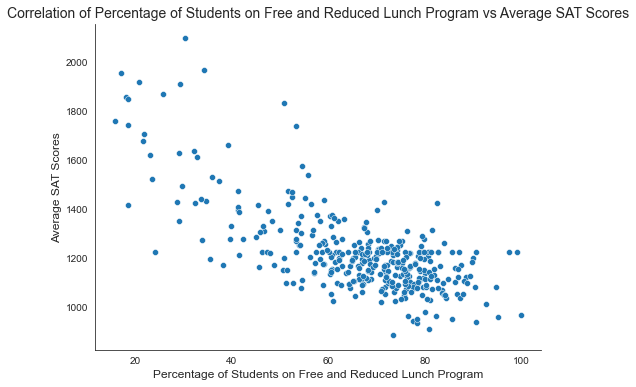

In [150]:
# scatterplot of FRL percent vs Average SAT Score

fig = plt.figure(figsize=(8,6))
sns.set_style('white')

ax = sns.scatterplot(data=combined, x='frl_percent', y='sat_score')

# labels
ax.set_title('Correlation of Percentage of Students on Free and Reduced Lunch Program vs Average SAT Scores', 
             fontsize=14, fontweight=3)
ax.set_xlabel('Percentage of Students on Free and Reduced Lunch Program', fontsize=12)
ax.set_ylabel('Average SAT Scores', fontsize=12)

sns.despine()

Based on the scatterplot above, there is a strong negative correlation with the percentage of students on FRL and SAT score for schools. School where 60% or more of the students are on FRL programs do not have average SAT scores past about 1400. Likely, students from households with larger incomes, have more access to early childhood education, studying resources, tutors, and advanced programs compared to studetns from lower-income households. These advantages allow them to prepare for an exam like the SAT.

Additionally, [FRL is correlated with food insecurity](https://frac.org/programs/national-school-lunch-program/benefits-school-lunch) - or the lack of acces to food because of social or financial reasons. Lack of nutrition and poor diets contribute to a student's academic wellbeing. Schools with a higher percetage of FRL suggests that students live with food insecurity and households lack the resources to adequately feed their children. More time is spent on base needs compared to students from higher income backgrounds which means less time to study. 

### Racial Differences in SAT Scores

In [ ]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

In [ ]:
# scatterplot of hispanic_per vs Average SAT Score

fig = plt.figure(figsize=(8,6))
sns.set_style('white')

ax = sns.scatterplot(data=combined, x='hispanic_percent', y='sat_score')

# labels
ax.set_title('Correlation between Percentage of Hispanic Students vs Average SAT Scores', 
             fontsize=14, fontweight=3)
ax.set_xlabel('Percentage of Students on Free and Reduced Lunch Program', fontsize=12)
ax.set_ylabel('Average SAT Scores', fontsize=12)

sns.despine()

In [ ]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [ ]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

### Gender Differences in SAT Scores

In [ ]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

In [ ]:
# scatterplot of share of female students vs Average SAT Score

fig = plt.figure(figsize=(8,6))
sns.set_style('white')

ax = sns.scatterplot(data=combined, x='female_per', y='sat_score')

# labels
ax.set_title('Correlation between Percentage of Female Students vs Average SAT Scores', 
             fontsize=14, fontweight=3)
ax.set_xlabel('Percentage of Female Students', fontsize=12)
ax.set_ylabel('Average SAT Scores', fontsize=12)

sns.despine()

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [ ]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

In [ ]:
# looking at male students male students

# scatterplot of share of male students vs Average SAT Score

fig = plt.figure(figsize=(8,6))
sns.set_style('white')

ax = sns.scatterplot(data=combined, x='male_per', y='sat_score')

# labels
ax.set_title('Correlation between Percentage of Male Students vs Average SAT Scores', 
             fontsize=14, fontweight=3)
ax.set_xlabel('Percentage of Male Students', fontsize=12)
ax.set_ylabel('Average SAT Scores', fontsize=12)

sns.despine()

Text(0.5, 1.0, 'Share of Students Male Students vs SAT Score')

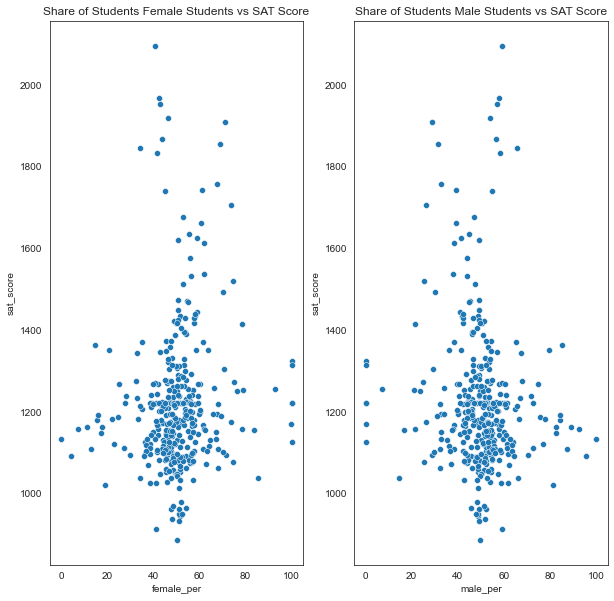

In [163]:
fig, axs= plt.subplots(ncols=2, figsize=(10,10))

f = sns.scatterplot(data=combined, x='female_per', y='sat_score', ax=axs[0])
m = sns.scatterplot(data=combined, x='male_per', y='sat_score', ax=axs[1])

f.set_title('Share of Students Female Students vs SAT Score')
m.set_title('Share of Students Male Students vs SAT Score')

These schools appears to be very selective liberal arts schools that have high academic standards.